In [1]:
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

import pickle

[nltk_data] Downloading package punkt to /Users/rmritik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers

2023-05-02 00:58:19.132882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
with open('bert_embeddings.pkl', 'rb') as fp:
    embed = pickle.load(fp)

In [4]:
data = pd.read_csv('malware_data.csv', index_col = 0)

In [5]:
counts_family = data.groupby('Malware Family')['Malware Family'].transform(len)
mask = (counts_family > 50)

In [6]:
data = data[mask]

In [7]:
nr_categories = len(data["Malware Family"].unique())

In [8]:
print(nr_categories)

7


In [9]:
from sklearn.preprocessing import LabelBinarizer
X = data['OpCode Sequence']
y_class = data['Malware Family']

lab = LabelBinarizer()
lab.fit(y_class)
y = lab.transform(y_class)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=data['Malware Family'])

In [11]:
voc = dict()
index = 1
for word in embed:
    voc[word] = index
    index = index + 1

In [12]:
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [13]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
X_train_seq = []
for sent in X_train:
    row = []
    marked_sent = "[CLS] " + sent + " [SEP]"
    tokenized_sent = tokenizer.tokenize(marked_sent)
    for token in tokenized_sent:
        if token in voc:
            row.append(voc[token])
        else:
            row.append(0)
    row = np.array(row)
    X_train_seq.append(row)

X_train_seq = np.array(X_train_seq)

/var/folders/43/55xrz6yn351c1v3zrty2c19m0000gn/T/ipykernel_16413/1137261655.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_seq = np.array(X_train_seq)


In [15]:
X_test_seq = []
for sent in X_test:
    row = []
    marked_sent = "[CLS] " + sent + " [SEP]"
    tokenized_sent = tokenizer.tokenize(marked_sent)
    for token in tokenized_sent:
        if token in voc:
            row.append(voc[token])
        else:
            row.append(0)
    row = np.array(row)
    X_test_seq.append(row)

X_test_seq = np.array(X_test_seq)

/var/folders/43/55xrz6yn351c1v3zrty2c19m0000gn/T/ipykernel_16413/3884249052.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_seq = np.array(X_test_seq)


In [16]:
max_len = 5000

X_train_seq = kprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_len)

X_test_seq = kprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)

In [17]:
X_train_seq.shape

(6443, 5000)

In [18]:
max_words = len(reverse_voc)
emb_matrix = np.zeros((max_words + 1, 768))
for i in range(max_words):
    if reverse_voc[i+1] in embed:
        emb_matrix[i+1, :] = embed[reverse_voc[i+1]]

emb_size = emb_matrix.shape[1]

In [19]:
emb_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.15311825, -1.26154423,  0.36354655, ...,  0.27120295,
        -1.62261522,  0.66343653],
       [-1.81655717,  0.76884419,  2.60423923, ..., -0.41154504,
        -1.04752946,  2.58976007],
       ...,
       [-2.40886688,  1.4607203 ,  4.29616261, ..., -1.74678349,
         2.93846011,  5.93549967],
       [ 3.20535755,  3.2273612 ,  7.63589907, ..., -0.18000922,
        -3.4374373 ,  2.92637157],
       [-0.14406785, -3.96900225,  7.44196081, ..., -2.18475056,
         1.22847772, -2.93866467]])

In [20]:
input_ = layers.Input(shape = X_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

2023-03-02 21:15:35.741057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5000)]            0         
                                                                 
 embedding (Embedding)       (None, 5000, 768)         121344    
                                                                 
 bidirectional-lstm (Bidirec  (None, 30)               94080     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 classification (Dense)      (None, 7)                 455       
                                                             

In [22]:
history = model.fit(X_train_seq, y_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_test_seq, y_test))

Epoch 1/10
101/101 [==============================] - 440s 4s/step - loss: 0.7853 - accuracy: 0.7234 - val_loss: 0.5656 - val_accuracy: 0.8194
Epoch 2/10
101/101 [==============================] - 482s 5s/step - loss: 0.5161 - accuracy: 0.8501 - val_loss: 0.3589 - val_accuracy: 0.9106
Epoch 3/10
101/101 [==============================] - 409s 4s/step - loss: 0.4760 - accuracy: 0.8552 - val_loss: 0.3652 - val_accuracy: 0.9156
Epoch 4/10
101/101 [==============================] - 499s 5s/step - loss: 0.4706 - accuracy: 0.8549 - val_loss: 0.3972 - val_accuracy: 0.9069
Epoch 5/10
101/101 [==============================] - 476s 5s/step - loss: 0.4583 - accuracy: 0.8598 - val_loss: 0.3415 - val_accuracy: 0.9137
Epoch 6/10
101/101 [==============================] - 478s 5s/step - loss: 0.4278 - accuracy: 0.8813 - val_loss: 0.3481 - val_accuracy: 0.9125
Epoch 7/10
101/101 [==============================] - 473s 5s/step - loss: 0.4176 - accuracy: 0.8859 - val_loss: 0.3514 - val_accuracy: 0.9187

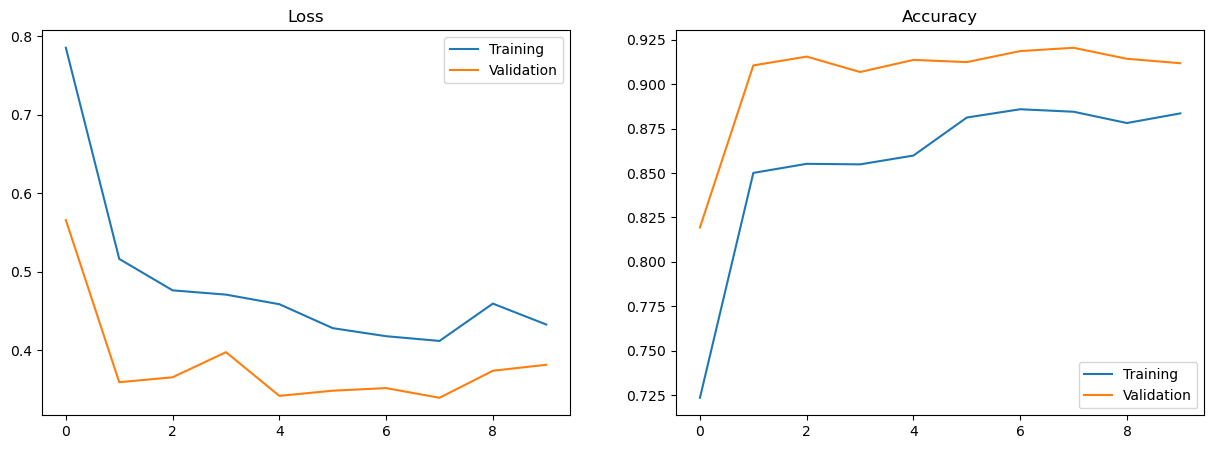

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [36]:
pickle.dump(model, open('BERT_with_TensorflowLSTM.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://668458b4-6db4-4169-856e-8c546881e0a6/assets


INFO:tensorflow:Assets written to: ram://668458b4-6db4-4169-856e-8c546881e0a6/assets


<h3> max_len = 1000

In [16]:
max_len = 1000

X_train_seq = kprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_len)

X_test_seq = kprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)

In [17]:
X_train_seq.shape

(6443, 1000)

In [18]:
max_words = len(reverse_voc)
emb_matrix = np.zeros((max_words + 1, 768))
for i in range(max_words):
    if reverse_voc[i+1] in embed:
        emb_matrix[i+1, :] = embed[reverse_voc[i+1]]

emb_size = emb_matrix.shape[1]

In [19]:
input_ = layers.Input(shape = X_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

2023-05-02 01:05:33.651038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 768)         121344    
                                                                 
 bidirectional-lstm (Bidirec  (None, 30)               94080     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 classification (Dense)      (None, 7)                 455       
                                                             

In [21]:
history = model.fit(X_train_seq, y_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_test_seq, y_test))

Epoch 1/10
101/101 [==============================] - 83s 806ms/step - loss: 0.7508 - accuracy: 0.7379 - val_loss: 0.4644 - val_accuracy: 0.9044
Epoch 2/10
101/101 [==============================] - 83s 817ms/step - loss: 0.5637 - accuracy: 0.8088 - val_loss: 0.4184 - val_accuracy: 0.8970
Epoch 3/10
101/101 [==============================] - 82s 817ms/step - loss: 0.5287 - accuracy: 0.8224 - val_loss: 0.3846 - val_accuracy: 0.9100
Epoch 4/10
101/101 [==============================] - 83s 819ms/step - loss: 0.5184 - accuracy: 0.8133 - val_loss: 0.3996 - val_accuracy: 0.8709
Epoch 5/10
101/101 [==============================] - 80s 792ms/step - loss: 0.5103 - accuracy: 0.8186 - val_loss: 0.3808 - val_accuracy: 0.8976
Epoch 6/10
101/101 [==============================] - 80s 796ms/step - loss: 0.4917 - accuracy: 0.8254 - val_loss: 0.3741 - val_accuracy: 0.9007
Epoch 7/10
101/101 [==============================] - 80s 794ms/step - loss: 0.4844 - accuracy: 0.8283 - val_loss: 0.3686 - val_ac

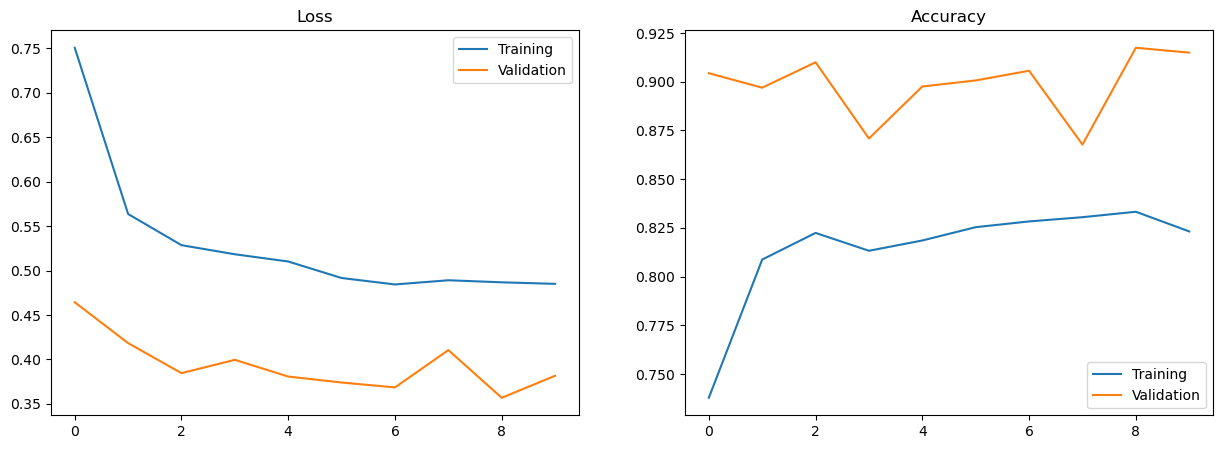

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

<h3> max_len = 2500

In [23]:
X_train_seq = []
for sent in X_train:
    row = []
    marked_sent = "[CLS] " + sent + " [SEP]"
    tokenized_sent = tokenizer.tokenize(marked_sent)
    for token in tokenized_sent:
        if token in voc:
            row.append(voc[token])
        else:
            row.append(0)
    row = np.array(row)
    X_train_seq.append(row)

X_train_seq = np.array(X_train_seq)

/var/folders/43/55xrz6yn351c1v3zrty2c19m0000gn/T/ipykernel_16413/1137261655.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_seq = np.array(X_train_seq)


In [24]:
X_test_seq = []
for sent in X_test:
    row = []
    marked_sent = "[CLS] " + sent + " [SEP]"
    tokenized_sent = tokenizer.tokenize(marked_sent)
    for token in tokenized_sent:
        if token in voc:
            row.append(voc[token])
        else:
            row.append(0)
    row = np.array(row)
    X_test_seq.append(row)

X_test_seq = np.array(X_test_seq)

/var/folders/43/55xrz6yn351c1v3zrty2c19m0000gn/T/ipykernel_16413/3884249052.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_seq = np.array(X_test_seq)


In [25]:
max_len = 2500

X_train_seq = kprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_len)

X_test_seq = kprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)

In [26]:
X_train_seq.shape

(6443, 2500)

In [27]:
max_words = len(reverse_voc)
emb_matrix = np.zeros((max_words + 1, 768))
for i in range(max_words):
    if reverse_voc[i+1] in embed:
        emb_matrix[i+1, :] = embed[reverse_voc[i+1]]

emb_size = emb_matrix.shape[1]

In [28]:
input_ = layers.Input(shape = X_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2500)]            0         
                                                                 
 embedding (Embedding)       (None, 2500, 768)         121344    
                                                                 
 bidirectional-lstm (Bidirec  (None, 30)               94080     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 classification (Dense)      (None, 7)                 455       
                                                           

In [30]:
history = model.fit(X_train_seq, y_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_test_seq, y_test))

Epoch 1/10
101/101 [==============================] - 190s 2s/step - loss: 0.5151 - accuracy: 0.8553 - val_loss: 0.3554 - val_accuracy: 0.9094
Epoch 2/10
101/101 [==============================] - 180s 2s/step - loss: 0.4029 - accuracy: 0.8873 - val_loss: 0.3148 - val_accuracy: 0.9100
Epoch 3/10
101/101 [==============================] - 1201s 12s/step - loss: 0.3564 - accuracy: 0.9039 - val_loss: 0.2813 - val_accuracy: 0.9131
Epoch 4/10
101/101 [==============================] - 187s 2s/step - loss: 0.3765 - accuracy: 0.8898 - val_loss: 0.2886 - val_accuracy: 0.9205
Epoch 5/10
101/101 [==============================] - 183s 2s/step - loss: 0.3537 - accuracy: 0.9013 - val_loss: 0.2933 - val_accuracy: 0.9137
Epoch 6/10
101/101 [==============================] - 183s 2s/step - loss: 0.3552 - accuracy: 0.9010 - val_loss: 0.2852 - val_accuracy: 0.9112
Epoch 7/10
101/101 [==============================] - 181s 2s/step - loss: 0.3484 - accuracy: 0.9038 - val_loss: 0.2840 - val_accuracy: 0.91

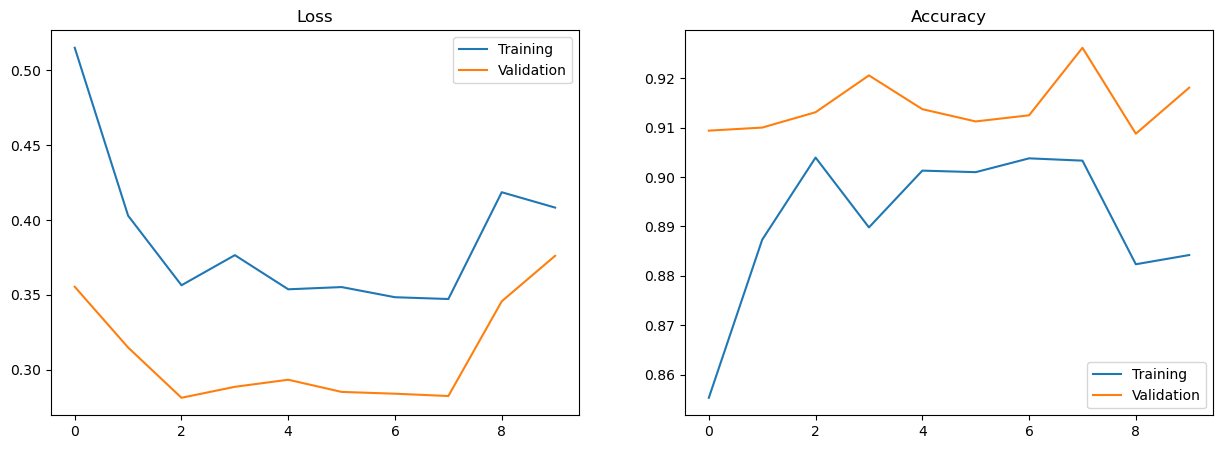

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")